In [1]:
#download dataset 
from google.colab import files
files.upload() # upload downloaded kaggle.json 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
# unzip data
!mkdir -p input
!unzip face-expression-recognition-dataset -d input/

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: input/images/validation/fear/8797.jpg  
  inflating: input/images/validation/fear/8818.jpg  
  inflating: input/images/validation/fear/886.jpg  
  inflating: input/images/validation/fear/9037.jpg  
  inflating: input/images/validation/fear/9040.jpg  
  inflating: input/images/validation/fear/9101.jpg  
  inflating: input/images/validation/fear/911.jpg  
  inflating: input/images/validation/fear/9179.jpg  
  inflating: input/images/validation/fear/9205.jpg  
  inflating: input/images/validation/fear/9232.jpg  
  inflating: input/images/validation/fear/9251.jpg  
  inflating: input/images/validation/fear/9261.jpg  
  inflating: input/images/validation/fear/9281.jpg  
  inflating: input/images/validation/fear/9302.jpg  
  inflating: input/images/validation/fear/9333.jpg  
  inflating: input/images/validation/fear/9369.jpg  
  inflating: input/images/validation/fear/9370.jpg  
  inflating: input/images/validation/fear/9474.

We will be training our model for the following 5 emotions:


*   Happy
*   Sad
*   Angry
*   Neutral
*   Surprise



Remove fear and disgust from the dataset.

In [2]:
!rm -rf "./input/images/train/fear/"
!rm -rf "./input/images/train/disgust/"

In [3]:
!rm -rf "./input/images/validation/fear/"
!rm -rf "./input/images/validation/disgust/"

Each image is grey-scaled and of resolution 48x48.

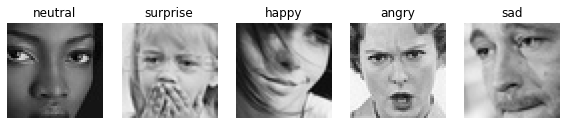

In [4]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "./input/images/"

train_data_dir = base_path +'train/'
validation_data_dir = base_path + 'validation/'

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_data_dir):
    img = load_img((train_data_dir + expression +'/'+ os.listdir(train_data_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()


We check the number of images for training.

In [5]:
nb_train_samples = 0
for expression in os.listdir(train_data_dir):
    nb_train_samples += len(os.listdir(train_data_dir + "/" + expression))
print(nb_train_samples)

24282


We check the number of images for validation.

In [6]:
nb_validation_samples = 0
for expression in os.listdir(validation_data_dir):
    nb_validation_samples += len(os.listdir(validation_data_dir + "/" + expression))
print(nb_validation_samples)

5937


We check the number of emotion categories we have and the number of images in each of those categories.

In [7]:
import pandas as pd

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + "/"+ expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_data_dir, 'train')
print(train_count)

       neutral  surprise  happy  angry   sad
train     4982      3205   7164   3993  4938


In [8]:
import pandas as pd

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + "/"+ expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(validation_data_dir, 'validation')
print(train_count)

            neutral  surprise  happy  angry   sad
validation     1216       797   1825    960  1139


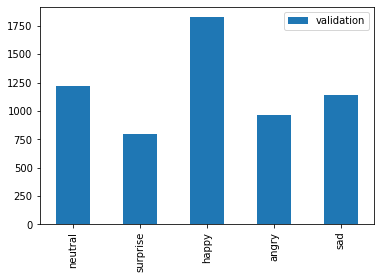

In [9]:
train_count.transpose().plot(kind='bar')

Data Augmentation:


*   Rescaling 
*   Rotation 
*   Width range 
*   Height range
*   Horizontal flip 
*   Zoom 


In [10]:
num_classes = 5
img_rows,img_cols = 48,48
batch_size = 32

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    color_mode='grayscale',
                    target_size=(img_rows,img_cols),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                            validation_data_dir,
                            color_mode='grayscale',
                            target_size=(img_rows,img_cols),
                            batch_size=batch_size,
                            class_mode='categorical',
                            shuffle=True)


Found 24282 images belonging to 5 classes.
Found 5937 images belonging to 5 classes.


In [12]:
train_generator.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}

Modeling: 

*   Optimizing the model using relu activation function. 
*   Doubling the number of kernels as 32, 64, 128, and 256.
*   For generalization purpose dropouts are used at regular intervals.
*   Batch Normalization is also used for better results


In [13]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPool2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

# Initialising the CNN

model= Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [14]:
# compile the model using Adam optimize

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Saving model using ModelCheckpoint, EarlyStopping for avoiding over-fitting and ReduceLROnPlateu for reducing learning rate whenever the validation accuracy plateaus occurs.

In [15]:
checkpoint = ModelCheckpoint('Emotion_face_2.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]


epochs=50

## train the model 

history=model.fit(
                train_generator,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator)


Epoch 1/50
759/759 [==============================] - 86s 49ms/step - loss: 9.0898 - accuracy: 0.2501 - val_loss: 7.7793 - val_accuracy: 0.3315

Epoch 00001: val_loss improved from inf to 7.77931, saving model to face_emotion.h5
Epoch 2/50
759/759 [==============================] - 35s 47ms/step - loss: 7.6034 - accuracy: 0.2915 - val_loss: 6.2565 - val_accuracy: 0.3791

Epoch 00002: val_loss improved from 7.77931 to 6.25647, saving model to face_emotion.h5
Epoch 3/50
759/759 [==============================] - 35s 46ms/step - loss: 6.1006 - accuracy: 0.3307 - val_loss: 4.8443 - val_accuracy: 0.4332

Epoch 00003: val_loss improved from 6.25647 to 4.84433, saving model to face_emotion.h5
Epoch 4/50
759/759 [==============================] - 35s 47ms/step - loss: 4.7358 - accuracy: 0.3641 - val_loss: 3.8431 - val_accuracy: 0.4391

Epoch 00004: val_loss improved from 4.84433 to 3.84307, saving model to face_emotion.h5
Epoch 5/50
759/759 [==============================] - 35s 47ms/step - lo

In [16]:
#model.save_weights("face_emotion.h5")


Plot the training and validation metrics

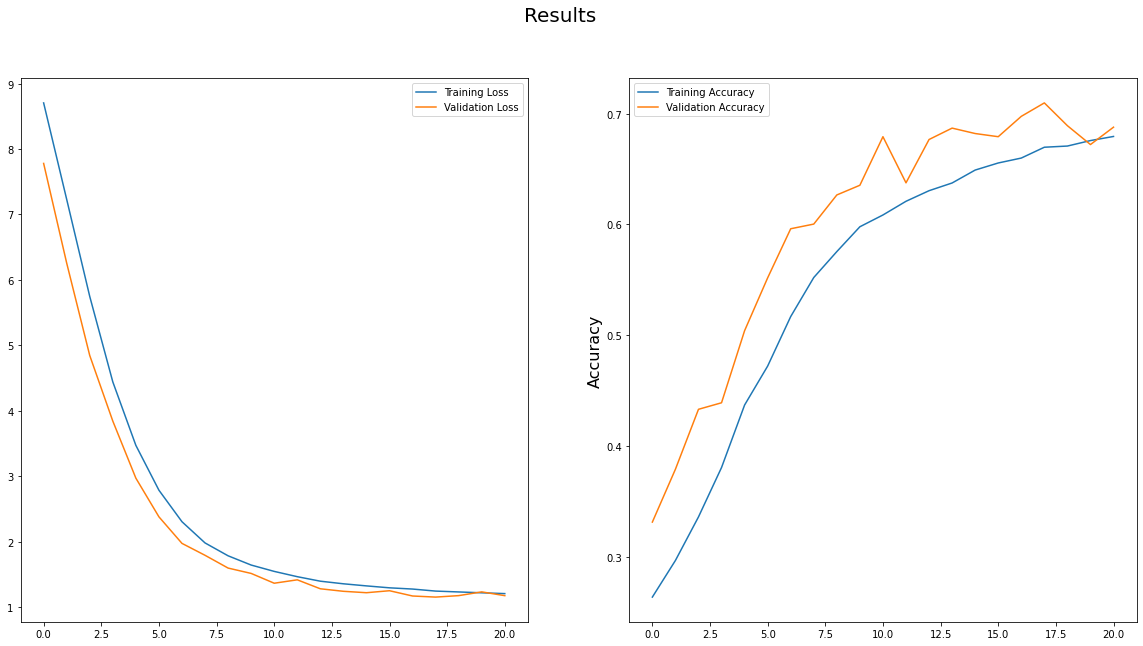

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.suptitle('Results',fontsize=20)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.ylabel("Accuracy",fontsize=16)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend()
plt.show()

Save model for latter use.

In [18]:
from google.colab import files
files.download('Emotion_face_2.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>